In [2]:
import os
import polars as pl
import duckdb
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import psutil

In [3]:
base_path = "leash-BELKA"

# Benchmark 2: filtering, grouping, and sorting

In [4]:
# Helper function to get memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024**2)  # Convert bytes to MB


def benchmark_polars(file_path, min_count=15):
    start_time = time.time()
    mem_before = get_memory_usage()

    if "parquet" in file_path:
        lazy_df = pl.scan_parquet(file_path)
    else:
        lazy_df = pl.scan_csv(file_path)

    # Perform filtering, grouping, and counting
    result = (
        lazy_df.filter(pl.col("binds") == 1)
        .group_by("protein_name")
        .agg([pl.count()])
        .filter(pl.col("count") >= min_count)
        .sort("count", descending=True)
        .collect()
    )

    elapsed_time = time.time() - start_time
    mem_consumed = abs(get_memory_usage() - mem_before)
    return elapsed_time, mem_consumed, result.head(10)


def benchmark_duckdb(file_path, min_count=15):
    start_time = time.time()
    mem_before = get_memory_usage()

    con = duckdb.connect()

    # Query using DuckDB for filtering, grouping, and sorting
    if "parquet" in file_path:
        result = con.execute(
            f"""
            SELECT protein_name, COUNT(*) as count
            FROM parquet_scan('{file_path}')
            WHERE binds=0
            GROUP BY protein_name
            HAVING count >= {min_count}
            ORDER BY count DESC
        """
        ).df()
    else:
        result = con.execute(
            f"""
            SELECT protein_name, COUNT(*) as count
            FROM read_csv_auto('{file_path}')
            WHERE binds=0
            GROUP BY protein_name
            HAVING count >= {min_count}
            ORDER BY count DESC
        """
        ).df()

    elapsed_time = time.time() - start_time
    mem_consumed = abs(get_memory_usage() - mem_before)
    return elapsed_time, mem_consumed, result.head(10)

In [7]:
runtime, mem, result = benchmark_polars(
    os.path.join(base_path, "train.parquet"), min_count=15
)
print("Time:", runtime)
print("RAM:", mem)
print(result)

C:\Users\predator\AppData\Local\Temp\ipykernel_15340\1128764582.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg([pl.count()])


Time: 0.6399555206298828
RAM: 19.1328125
shape: (3, 2)
┌──────────────┬────────┐
│ protein_name ┆ count  │
│ ---          ┆ ---    │
│ str          ┆ u32    │
╞══════════════╪════════╡
│ sEH          ┆ 724532 │
│ BRD4         ┆ 456964 │
│ HSA          ┆ 408410 │
└──────────────┴────────┘


In [8]:
runtime, mem, result = benchmark_duckdb(
    os.path.join(base_path, "train.parquet"), min_count=15
)
print("Time:", runtime)
print("RAM:", mem)
print(result)

Time: 0.7993259429931641
RAM: 4.9140625
  protein_name     count
0          HSA  98007200
1         BRD4  97958646
2          sEH  97691078


# Start benchmark

In [5]:
### Run the benchmarks multiple times and store results ###
def run_benchmarks(parquet_file, n_runs=5, is_polar=True):
    results = []
    for i in tqdm(range(n_runs)):
        if is_polar:
            # Run Polars benchmark
            runtime, mem, result = benchmark_polars(parquet_file)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "Polars Time": runtime,
                    "Polars Memory (MB)": mem,
                }
            )
        else:
            # Run DuckDB benchmark
            runtime, mem, result = benchmark_duckdb(parquet_file)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "DuckDB Time": runtime,
                    "DuckDB Memory (MB)": mem,
                }
            )

        # wait for release memory
        time.sleep(5)

    return results

In [6]:
def plot_results(df_output, title1, title2):
    # Plot the benchmark times for comparison
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(
        df_output["Run"], df_output["Polars Time"], label="Polars Time", marker="s"
    )
    plt.plot(
        df_output["Run"], df_output["DuckDB Time"], label="DuckDB Time", marker="^"
    )
    plt.title(title1)
    plt.xlabel("Run")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(
        df_output["Run"],
        df_output["Polars Memory (MB)"],
        label="Polars Memory",
        marker="s",
    )
    plt.plot(
        df_output["Run"],
        df_output["DuckDB Memory (MB)"],
        label="DuckDB Memory",
        marker="^",
    )
    plt.title(title2)
    plt.xlabel("Run")
    plt.ylabel("Memory Usage (MB)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Parquet benchmark

In [11]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.parquet"), n_runs=50)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\predator\AppData\Local\Temp\ipykernel_15340\1128764582.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg([pl.count()])
100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


In [12]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.parquet"), n_runs=50, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


In [13]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,0.657539,61.835938,0.940854,3.292969
1,2,0.630889,23.136719,0.900239,2.429688
2,3,0.612768,14.160156,0.902714,1.871094
3,4,0.637499,16.214844,0.894492,2.363281
4,5,0.637365,13.660156,0.946332,3.554688


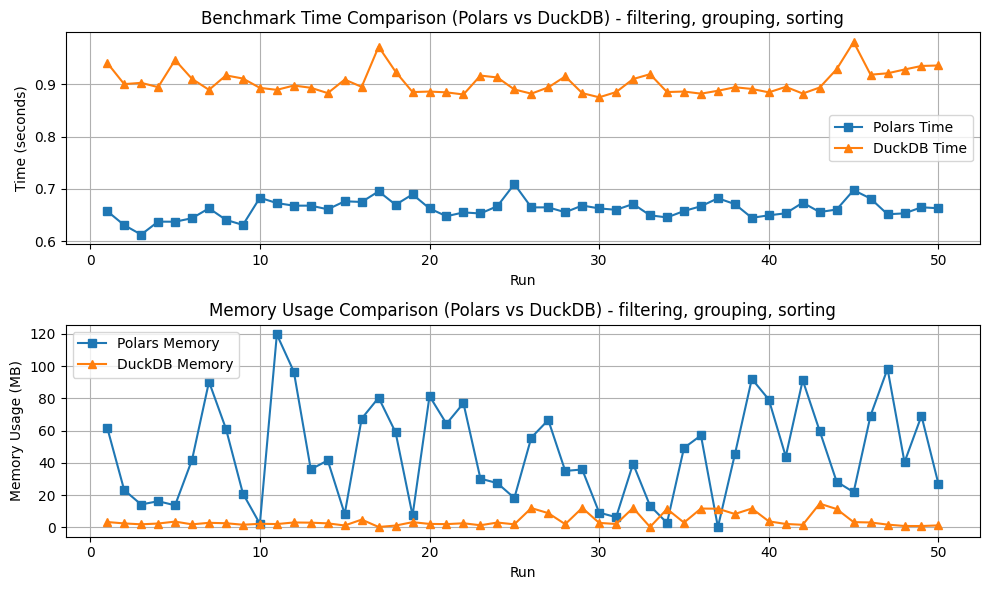

In [14]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
plot_results(df_results, title1, title2)

## CSV benchmark

In [7]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.csv"), n_runs=5)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\predator\AppData\Local\Temp\ipykernel_16948\2916875437.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg([pl.count()])
100%|██████████| 5/5 [04:40<00:00, 56.06s/it]


In [8]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.csv"), n_runs=5, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 5/5 [03:51<00:00, 46.24s/it]


In [9]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,42.190520,15.128906,40.992746,24.246094
1,2,46.095324,3.398438,40.655976,4.847656
2,3,53.195618,30.921875,40.842117,3.054688
3,4,55.245141,16.507812,42.091806,5.886719
4,5,58.440280,1.179688,41.557493,6.078125


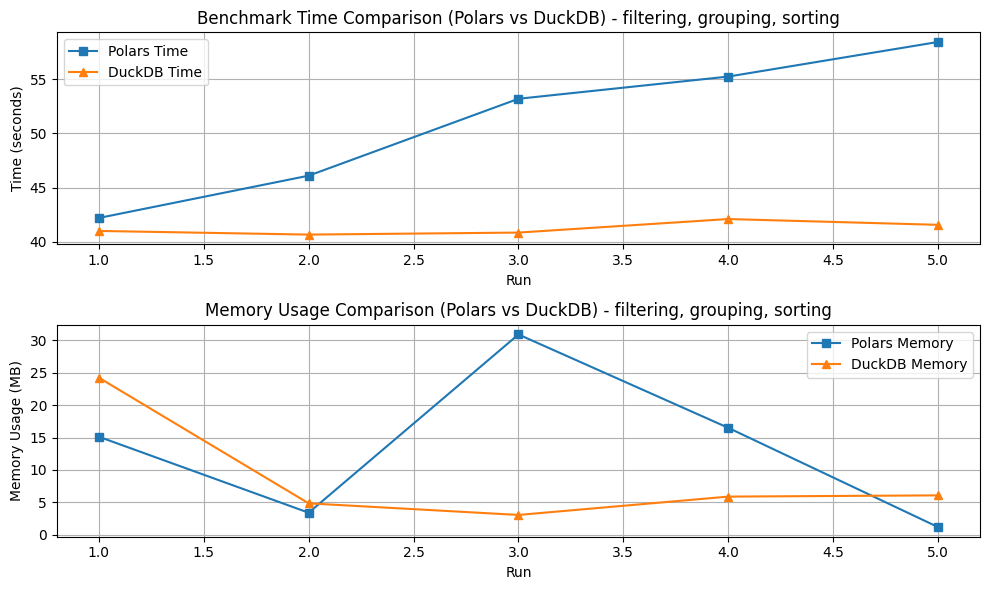

In [10]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - filtering, grouping, sorting"
plot_results(df_results, title1, title2)